# Apply Attention to Subtraction Datasets.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from src.data_gen import subtraction_datasets, to_ID, to_batch

In [2]:
embedding_dim = 200
hidden_dim = 128
vocab_size = len(to_ID())

BATCH_NUM = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
input_data, output_data = subtraction_datasets(record_num=50000)
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size=0.7)
criterion = nn.CrossEntropyLoss()

# Encoder
* LSTM has cell-state, but GRU does not have cell-state.

In [4]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=to_ID()[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        hs, h = self.gru(embedding)
        # GRU has no cell-state!
        return hs, h

# Attention-Decoder

In [5]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, num_layers=1):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=to_ID()[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim * 2: concat GRU hidden dim and Attention context-vector.
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # dim=1 is input_time-sequence.
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)
        
        # Attention layer.
        # t_output format: [batch_size, emb_vec, output_time_seq]
        t_output = torch.transpose(output, 1, 2)
        
        # hs_format: [batch_size, input_time_seq, emb_vec]
        # s_format: [batch_size, input_time_seq, output_time_seq]
        s = torch.bmm(hs, t_output)
        
        # atteintion_weight.shape == s.shape
        attention_weight = self.softmax(s)
        
        # c_format: [batch_size, 1, emb_vec]
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device)
        
        for i in range(attention_weight.size()[2]):
            # unsq_weight: [batch_size, input_time_seq, 1]
            unsq_weight = attention_weight[:, :, i].unsqueeze(2)
            # hs_format: [batch_size, input_time_seq, emb_vec]
            # weited_hs_format: [batch_size, input_time_seq, emb_vec]
            weighted_hs = hs * unsq_weight
            # weight_sum_format: [batch_size, 1, emb_vec]
            weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1)
            # c_format: [batch_size, i, emb_vec]
            c = torch.cat([c, weight_sum], dim=1)
            
        # rm zero elm.
        c = c[:, 1:, :]
        #print("output.shape, c.shape: ", output.shape, c.shape)
        output = torch.cat([output, c], dim=2)
        output = self.hidden2linear(output)

        return output, state, attention_weight

In [10]:
def train(EPOCH_NUM=100, lr=0.001):
    all_losses = []
    print("training...")
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    
    for epoch in range(1, EPOCH_NUM + 1):
        epoch_loss = 0

        input_batch, output_batch = to_batch(train_x, train_y, batch_size=BATCH_NUM)

        for i in range(len(input_batch)):
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            input_ts = torch.tensor(input_batch[i], device=device)
            output_ts = torch.tensor(output_batch[i], device=device)

            hs, h = encoder(input_ts)

            # last-data can not be next-input.
            training_source = output_ts[:, :-1]
            # start symbol can not ba data to train.
            training_data = output_ts[:, 1:]

            loss = 0

            decoder_output, _, attention_weight = decoder(training_source, hs, h)

            for j in range(decoder_output.size()[1]):
                loss += criterion(decoder_output[:, j, :], training_data[:, j])

            epoch_loss += loss.item()
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

        print("Epoch %d: %.2f" % (epoch, epoch_loss))
        all_losses.append(epoch_loss)
        if epoch_loss < 0.1: break
    print("Done")
    
    return all_losses

In [11]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers=1).to(device)
decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, batch_size=BATCH_NUM).to(device)

# Training

In [12]:
all_losses = train(EPOCH_NUM=100, lr=0.001)

training...
Epoch 1: 1830.69
Epoch 2: 1353.65
Epoch 3: 1258.62
Epoch 4: 1204.07
Epoch 5: 1166.44
Epoch 6: 1121.16
Epoch 7: 1068.28
Epoch 8: 1013.40
Epoch 9: 950.09
Epoch 10: 885.29
Epoch 11: 820.29
Epoch 12: 751.43
Epoch 13: 683.25
Epoch 14: 615.33
Epoch 15: 555.47
Epoch 16: 509.35
Epoch 17: 457.02
Epoch 18: 423.97
Epoch 19: 386.41
Epoch 20: 353.11
Epoch 21: 335.40
Epoch 22: 306.46
Epoch 23: 290.85
Epoch 24: 269.47
Epoch 25: 255.80
Epoch 26: 247.60
Epoch 27: 228.17
Epoch 28: 225.45
Epoch 29: 207.21
Epoch 30: 205.78
Epoch 31: 199.31
Epoch 32: 188.90
Epoch 33: 180.81
Epoch 34: 177.93
Epoch 35: 167.50
Epoch 36: 155.28
Epoch 37: 166.15
Epoch 38: 146.07
Epoch 39: 158.60
Epoch 40: 149.91
Epoch 41: 130.30
Epoch 42: 139.53
Epoch 43: 147.29
Epoch 44: 126.51
Epoch 45: 123.56
Epoch 46: 116.78
Epoch 47: 116.63
Epoch 48: 116.91
Epoch 49: 118.55
Epoch 50: 116.17
Epoch 51: 111.70
Epoch 52: 95.54
Epoch 53: 102.68
Epoch 54: 106.21
Epoch 55: 85.47
Epoch 56: 88.51
Epoch 57: 91.11
Epoch 58: 88.10
Epoch 59

In [17]:
all_losses = train(EPOCH_NUM=50, lr=0.0003)

training...
Epoch 1: 45.14
Epoch 2: 38.99
Epoch 3: 46.78
Epoch 4: 42.67
Epoch 5: 45.25
Epoch 6: 29.98
Epoch 7: 38.07
Epoch 8: 36.65
Epoch 9: 50.36
Epoch 10: 25.96
Epoch 11: 41.55
Epoch 12: 45.48
Epoch 13: 34.92
Epoch 14: 31.89
Epoch 15: 23.92
Epoch 16: 57.05
Epoch 17: 34.55
Epoch 18: 18.34
Epoch 19: 21.38
Epoch 20: 53.32
Epoch 21: 38.47
Epoch 22: 28.18
Epoch 23: 43.21
Epoch 24: 27.70
Epoch 25: 14.35
Epoch 26: 11.60
Epoch 27: 49.58
Epoch 28: 58.40
Epoch 29: 22.14
Epoch 30: 12.67
Epoch 31: 9.53
Epoch 32: 8.90
Epoch 33: 106.87
Epoch 34: 46.70
Epoch 35: 34.14
Epoch 36: 25.95
Epoch 37: 12.51
Epoch 38: 9.52
Epoch 39: 50.79
Epoch 40: 34.09
Epoch 41: 23.85
Epoch 42: 14.25
Epoch 43: 47.35
Epoch 44: 37.34
Epoch 45: 15.79
Epoch 46: 8.32
Epoch 47: 6.63
Epoch 48: 5.95
Epoch 49: 27.94
Epoch 50: 113.54
Done


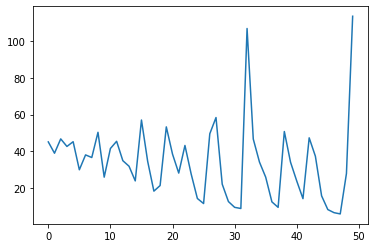

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

# Prediction

In [19]:
def get_max_index(decoder_output):
    #print('get_max_index: decoder_output.shape: ', decoder_output.shape)
    #torch.Size([100, 13])
    
    results = []
    for h in decoder_output:
        #print(torch.argmax(h).shape)
        #torch.Size([])
        #print(torch.argmax(h))
        #tensor(11, device='cuda:0')

        results.append(torch.argmax(h))
        
    results = torch.tensor(results, device=device).view(BATCH_NUM, 1)
    #print(results.shape)
    #torch.Size([100, 1])
    return results

In [20]:
test_input_batch, test_output_batch = to_batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad(): 
        hs, h = encoder(input_tensor[i])
        hidden_state = h

        # Add start symbol.
        start_char_batch = [[to_ID()["_"]] for _ in range(BATCH_NUM)]
        decoder_input_tensor = torch.tensor(start_char_batch, device=device)

        # store prediction.
        batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
        # print(batch_tmp.size())
        # (100,1)

        for _ in range(5):
            decoder_output, hidden_state, _ = decoder(decoder_input_tensor, hs, hidden_state)
            #print('decoder_output.shape: ', decoder_output.shape)
            #decoder_output.shape:  torch.Size([100, 1, 13])

            # output(predicted character) will be next input.
            decoder_input_tensor = get_max_index(decoder_output.squeeze())
        
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)

            # remove head element.
            #print('batch_tmp[:, 1:]: ', batch_tmp[:, 1:])
            #batch_tmp[:, 1:]:  tensor([[11],
        predicts.append(batch_tmp[:,1:])

print(len(predicts))
# 150
print(predicts[0].size())
# (100, 5)

150
torch.Size([100, 5])


In [21]:
import pandas as pd
id2char = {str(i) : str(i) for i in range(10)}
id2char.update({"10":"", "11":"-", "12":""})
row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[str(idx)] for idx in inp]
        y = [id2char[str(idx)] for idx in output]
        p = [id2char[str(idx.item())] for idx in predict]

        x_str = "".join(x)
        y_str = "".join(y)
        p_str = "".join(p)

        judge = "O" if y_str == p_str else "X"
        row.append([x_str, y_str, p_str, judge])
        
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

# accuracy
print(len(predict_df.query('judge == "O"')) / len(predict_df))
# show wrong predictions.
print(predict_df.query('judge == "X"').head(10))

0.8909333333333334
       input answer predict judge
30    64-774   -710    -700     X
34    80-201   -121    -120     X
46     99-52     47      57     X
67    108-82     26      16     X
73   796-152    644     674     X
101  769-159    610     600     X
102   762-63    699     799     X
126  103-594   -491    -481     X
135  982-657    325     315     X
143  286-952   -666    -676     X
